In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
import requests
import pickle
import glob
from datetime import datetime
from ast import literal_eval as make_tuple

from functions.util import get_trade, get_prod

## Setup

In [2]:
sns.set_style("whitegrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# For 2019
countries = ['DE','CH','AL',     'AT',     'BA','BE','BG','BY','CY','CZ','DK','EE','ES','FI','FR','GE','GR','HR','HU','IE','IT','LT','LU','LV','MD','ME','MK','MT','NIE','NL','NO','PL','PT','RO','RS','RU','SE','SI','SK','TR','UA','UK','XK']
# Countries we want to import, for 2021
countries = ['DE','CH','AL','AM','AT','AZ','BA','BE','BG','BY','CY','CZ','DK','EE','ES','FI','FR','GE','GR','HR','HU','IE','IT','LT','LU','LV','MD','ME','MK','MT','NIE','NL','NO','PL','PT','RO','RS','RU','SE','SI','SK','TR','UA','UK','XK']

## Scraping the data
Please don't run this part if you already have saved the time series you need. This is bandwidth-consuming (mostly for the server side). The data is publicly available from https://energy-charts.info, which is an amazing visualisation website, not a data repository.

In [10]:
year = '2022'

if  f'.\\prod_and_trade_data_{year}.pickle' in glob.glob('./*'):
    
    f = open(f'.\\prod_and_trade_data_{year}.pickle', 'rb')
    data = pickle.load(f)
    
else:
    
    # Data grab
    data = dict()

    for country in countries:
        country = country.lower()

        print(country)
        prod_df, _, _ = get_prod(country=country, # country code
                                        step='hour',
                                 year=year,  # year
                                 display=False, # display chart (or just save data)
                                 load=True,    # show load
                                 cumul=False,  # cumulative
                                 rolling=1,   # rolling average, in timesteps
                                 lang='en')    # language
        print('...production OK')

        trade_df, _ = get_trade(year=year,
                                country=country,
                                lang='en',
                                display=False)
        print('...trade OK')

        data[country] = {'production mix': prod_df,
                         'trade': trade_df}

    f = open(f'.\\prod_and_trade_data_{year}.pickle', 'wb')
    pickle.dump(data , f)

de
https://energy-charts.info/charts/power/data/de/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/de/year_cbpf_saldo_2022.json
...trade OK
ch
https://energy-charts.info/charts/power/data/ch/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/ch/year_cbpf_saldo_2022.json
...trade OK
al
https://energy-charts.info/charts/power/data/al/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/al/year_cbpf_saldo_2022.json
...trade OK
am
https://energy-charts.info/charts/power/data/am/year_2022.json
'Load'
...production OK
https://energy-charts.info/charts/power/data/am/year_cbpf_saldo_2022.json
...trade OK
at
https://energy-charts.info/charts/power/data/at/year_2022.json
...production OK
https://energy-charts.info/charts/power/data/at/year_cbpf_saldo_2022.json
...trade OK
az
https://energy-charts.info/charts/power/data/az/year_2022.json
'Load'
...production OK
https://energy-charts.info/charts/power/data/az/year_cbpf_

Getting the colors for the charts. Germany and Estonia should cover all sources.

In [11]:
_, _, colors_de = get_prod(country='de', # country code
                                step='year',
                         year=year,  # year
                         display=False, # display chart (or just save data)
                         load=True,    # show load
                         cumul=False,  # cumulative
                         rolling=1,   # rolling average, in timesteps
                         lang='en')    # language

https://energy-charts.info/charts/energy/data/de/year_2022.json


In [12]:
_, _, colors_ee = get_prod(country='ee', # country code
                                step='year',
                         year=year,  # year
                         display=False, # display chart (or just save data)
                         load=True,    # show load
                         cumul=False,  # cumulative
                         rolling=1,   # rolling average, in timesteps
                         lang='en')    # language

https://energy-charts.info/charts/energy/data/ee/year_2022.json


In [14]:
colors = {**colors_de, **colors_ee}

## Making sense of the collected data
It would be too nice if all data were harmonised, of course it is not. Let's first collect the full list of technologies and trade partners.

In [15]:
techs = []
partners = []

for country, datasets in data.items():
    try:
        techs.extend(datasets['production mix'].columns)
        partners.extend(datasets['trade'].columns)
    except:
        pass

In [16]:
# This is only to get the country codes, we don't use the rest of the file
gen_units_per_country = pd.read_csv('generation_units_by_country_2019.csv', index_col=1)['short']

In [17]:
country_codes = {p: gen_units_per_country.loc[p] for p in set(partners) if p in gen_units_per_country.index}

In [18]:
# What are we missing?
set(partners) ^ country_codes.keys()

{'Armenia',
 'Azerbaijan',
 'Ireland',
 'Malta',
 'North Macedonia',
 'Serbia',
 'Slovakia',
 'sum'}

In [19]:
# Add the remaining countries by hand... this will also exclude "sum" from the trade data
country_codes = {**country_codes, **{
                                     'Armenia':'AM',
                                     'Azerbaijan':'AZ',
                                     'Ireland':'IE',
                                     'Malta':'MT',
                                     'North Macedonia':'MK',
                                     'Serbia':'RS',
                                     'Slovakia':'SK'}}

The list of techs is not unique, muhaha.

In [20]:
techs_agg = {'Hydro pumped storage consumption': 'Hydro pumped storage consumption',
               'Import Balance': 'Import balance',
               'Biomass': 'Biomass',
               'Fossil gas': 'Fossil gas',
               'Fossil oil': 'Fossil oil',
               'Fossil oil shale': 'Fossil oil shale',
               'Fossil peat': 'Fossil peat',
               'Hydro pumped storage': 'Hydro pumped storage generation',
               'Hydro Pumped Storage': 'Hydro pumped storage generation',
               'Hydro Run-of-River': 'Hydro run-of-river',
               'Nuclear': 'Nuclear',
               'Others': 'Others',
               'Solar': 'Solar',
               'Waste': 'Waste non-renewable',
               'Wind offshore': 'Wind',
               'Wind onshore': 'Wind',
               'Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Hydro Power': 'Hydro',
               'Uranium': 'Nuclear',
               'Brown Coal': 'Brown coal',
               'Other renewables': 'Other renewables',
               'Hard Coal': 'Hard coal',
               'Oil': 'Fossil oil',
               'Gas': 'Fossil gas',
               'Pumped Storage generation': 'Hydro pumped storage generation',
               'Wind': 'Wind',
               'Hydro Pumped Storage consumption': 'Hydro pumped storage consumption',
               'Fossil Brown Coal': 'Brown coal',
               'Fossil brown coal / lignite': 'Brown coal',
               'Fossil Hard Coal': 'Hard coal',
               'Fossil Oil': 'Fossil oil',
               'Fossil Gas': 'Fossil gas',
               'Fossil coal-derived gas': 'Fossil coal-derived gas',
               'Hydro Pumped Storage generation': 'Hydro pumped storage generation',
               'Hydro Water Reservoir': 'Hydro',
               'Hydro water reservoir': 'Hydro',
               'Geothermal': 'Geothermal',
               'Fossil hard coal': 'Hard coal',
               'Waste renewable':'Waste renewable',
               'Waste non-renewable':'Waste non-renewable'}

In [21]:
colors_harmonized = dict()

for k,v in colors.items():
    if k not in ['Load', 'Residual load', 'Renewable share of generation', 'Renewable share of load'] and not k.startswith('_'):
        colors_harmonized[techs_agg[k]] = v

In [23]:
# Now let's check the shape of the various tables we have
for country in data.keys():
    
    for kk,vv in data[country].items():
        
        if vv is not None:
            print(country,kk,vv.shape)

de production mix (35040, 19)
de trade (35040, 12)
ch production mix (8760, 9)
ch trade (35040, 5)
al production mix (32544, 1)
al trade (8760, 4)
am production mix (8196, 1)
am trade (8760, 2)
at production mix (35040, 14)
at trade (35040, 7)
az production mix (8196, 1)
az trade (8760, 2)
ba production mix (8760, 8)
ba trade (8760, 4)
be production mix (8760, 15)
be trade (35040, 6)
bg production mix (8760, 14)
bg trade (8760, 6)
by production mix (8196, 1)
by trade (8760, 3)
cy production mix (7655, 4)
cz production mix (8760, 19)
cz trade (8760, 5)
dk production mix (8760, 11)
dk trade (35040, 5)
ee production mix (8760, 13)
ee trade (8760, 4)
es production mix (8760, 17)
es trade (8760, 3)
fi production mix (8760, 14)
fi trade (8760, 5)
fr production mix (8760, 15)
fr trade (8760, 7)
ge production mix (8760, 7)
ge trade (8760, 5)
gr production mix (8760, 7)
gr trade (8760, 6)
hr production mix (8760, 16)
hr trade (8760, 5)
hu production mix (35040, 17)
hu trade (35040, 8)
ie produc

## Cleaning
The next steps are cleaning steps:

- aggregate technology names into the single set of names we defined,
- match country names with their unique code,
- scale the values, trade is in MWh while production is in GWh (except Germany, God knows why).

In [24]:
data_clean = dict()
agg_dict = {'production mix': techs_agg,
            'trade': country_codes}
scale_dict = {'production mix': 1,
              'trade': 1000}

for country in data.keys():
    
    data_clean[country.upper()] = dict()
    
    for k,v in data[country].items():
        
        if v is not None:
            data_clean[country.upper()][k] = v.groupby(agg_dict[k], axis=1).sum().resample("h").mean() * scale_dict[k]

# For some years, German data is not in the same unit

#             if country=='de' and k=='production mix':
#                 data_clean[country.upper()][k] *= 1000
            
#             if country=='de' and k=='trade':
#                 data_clean[country.upper()][k] /= 1000


## Treatment
Now we will actually use the data for our objectives.

In [25]:
# Lots of concatenation to obtain a single dataframe containing all the data we want
P = pd.concat([pd.concat({country: pd.concat(data_clean[country], axis=1)}, axis=1, names=['country','type','source']) for country in data_clean.keys()], axis=1)

### Test for one specific hour of the year

In [26]:
# For the production-consumption adjustment, we have to pick a given hour in the year.
hour=4000

T = P.iloc[hour].unstack('country').fillna(0)
time=P.index[hour]

<AxesSubplot:xlabel='country', ylabel='type-source'>

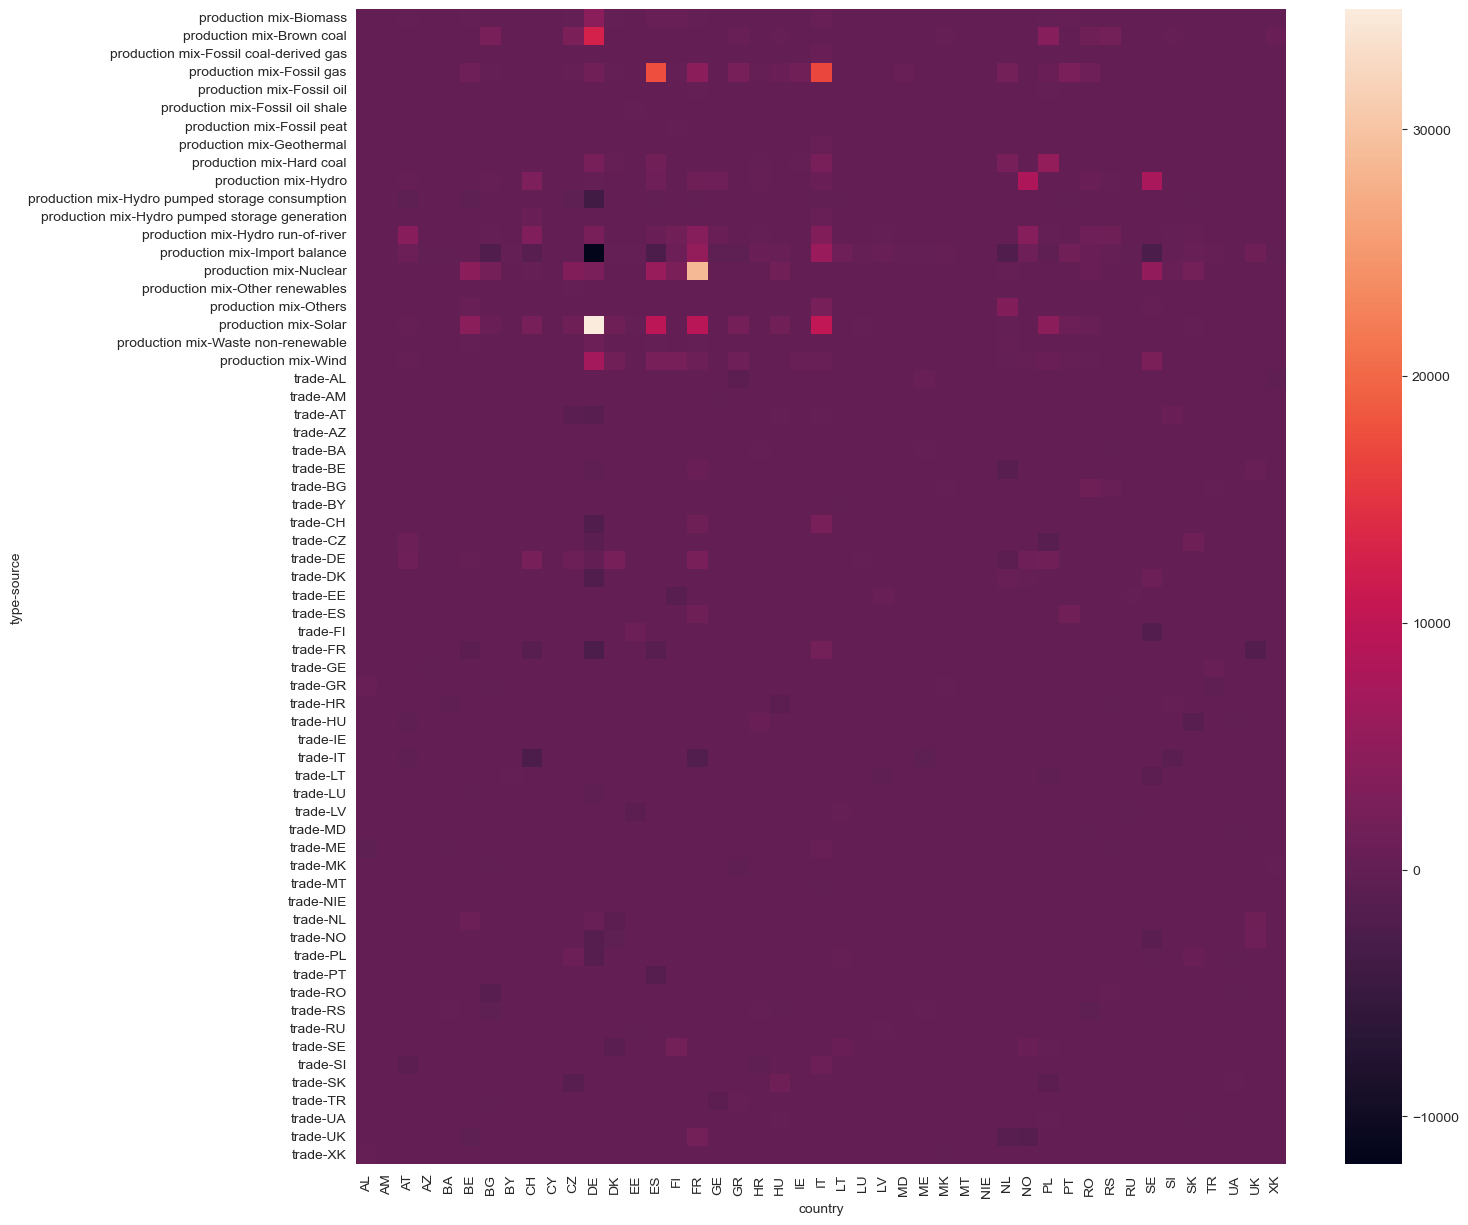

In [27]:
# So what happened on that hour? Let's make a heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(T, ax=ax)

In [28]:
# Check that trade matches import balance, there will be "border effects" for non-EU countries...
pd.concat([T.loc['trade'].sum(), T.loc[('production mix', 'Import balance')]], axis=1)

,0,"(production mix, Import balance)"
country,,
AL,485.2100,121.300
AM,94.7600,94.800
AT,922.3200,922.300
AZ,-119.4000,-119.400
BA,-178.0000,-178.000
BE,-12.5100,-16.800
BG,-2123.2200,-2123.200
BY,142.0000,142.000
CH,-1291.0850,-1292.900


In [29]:
# Drop import balance as it's already accounted for in the trade matrix
T.drop(('production mix', 'Import balance'), inplace=True)

In [30]:
# Get the full index of countries, the union set of columns (importers) and indices (exporters)
full_index = T.columns | T.loc['trade'].index

In [31]:
# Make T square again
T_sq = T.reindex(full_index, axis=1)

# Exports are already accounted for as imports (their off-diagonal counterparts)
T_sq.loc['trade'][T_sq.loc['trade'] < 0] = 0

# Now build the P matrix, containing share data
P_prod = (T_sq.loc['production mix']/T_sq.sum()).fillna(0)
P_trade = (T_sq.loc['trade'].reindex(full_index)/T_sq.sum()).fillna(0)

In [32]:
# The almighty matrix inversion
L_trade = pd.DataFrame(np.linalg.inv(np.eye(P_trade.shape[0]) - P_trade),
                       index=P_trade.index,
                       columns=P_trade.columns)

In [33]:
# The consumption mix equals the production mixes multiplied by the "full cycle"/resolved graph network
M = P_prod.dot(L_trade)

In [34]:
pd.concat([P_prod,P_trade],axis=0)

,AL,AM,AT,AZ,BA,BE,BG,BY,CH,CY,...,RO,RS,RU,SE,SI,SK,TR,UA,UK,XK
Biomass,0.000000,0.0,0.037602,0.0,0.0,0.023640,0.004521,0.0,0.0,0.0,...,0.008374,0.006864,0.0,0.0,0.002887,0.021528,0.0,0.0,0.0,0.000000
Brown coal,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.383820,0.0,0.0,0.0,...,0.161778,0.425328,0.0,0.0,0.182730,0.014937,0.0,0.0,0.0,0.783787
Fossil coal-derived gas,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Fossil gas,0.000000,0.0,0.000054,0.0,0.0,0.104566,0.035040,0.0,0.0,0.0,...,0.165262,0.022879,0.0,0.0,0.007236,0.018724,0.0,0.0,0.0,0.000000
Fossil oil,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.011149,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SK,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000
TR,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
UA,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.009914,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
UK,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [35]:
comparison = pd.concat([P_prod, M], axis=1, keys=['production','consumption']).sort_index(axis=1, level=1).swaplevel(axis=1)

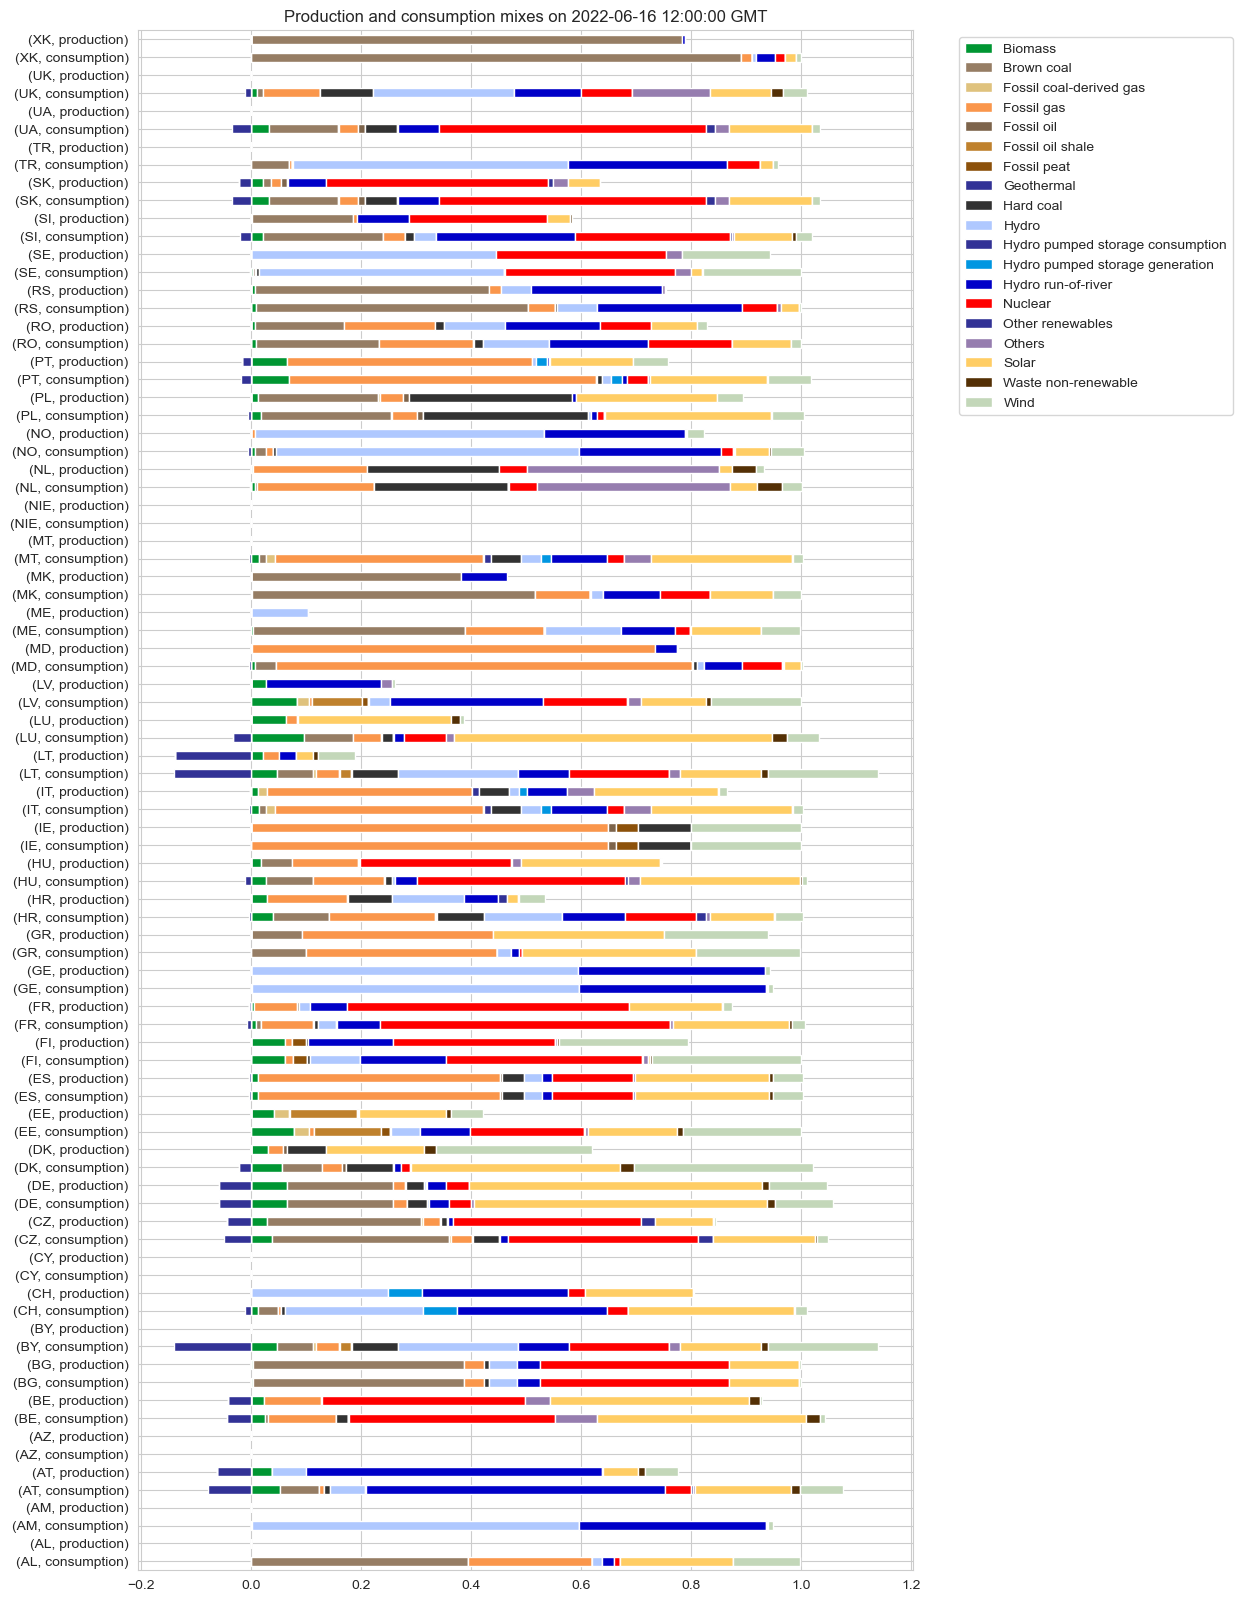

In [37]:
# Let's plot the comparison (some countries will yield strange values, namely RU and BA, probably scale, TO CHECK)
comparison.drop(['RU','BA'],axis=1).T.plot.barh(stacked=True,
                                                figsize=(10,20),
                                                title=f'Production and consumption mixes on {time} GMT',
                                                color=colors_harmonized)
plt.legend(bbox_to_anchor =(1.05, 1))

### Full year

In [38]:
n_r = full_index.shape[0] # number of regions

In [39]:
# full matrix of transactions
T_full = P.stack('country').fillna(0)
time_series = T_full.index.levels[0].tolist()

In [40]:
# get the shares of consumption from each source
T_full.drop(('production mix','Import balance'), axis=1, inplace=True)
T_full['trade'][T_full['trade']<0]=0
T_full = T_full.reindex(pd.MultiIndex.from_product([time_series, full_index])).fillna(0)
P_full = (T_full.div(T_full.sum(1),axis=0)).fillna(0)

In [41]:
P_full.index.names=['datetime', 'country']

In [42]:
full_columns = pd.MultiIndex.from_product([['production mix'],P_full['production mix'].columns]).union(pd.MultiIndex.from_product([['trade'],full_index]))

In [43]:
P_full = P_full.reindex(pd.MultiIndex.from_product([time_series, full_index])).reindex(full_columns, axis=1).fillna(0)

In [44]:
# example: this is the shares of French consumption from various sources (techs or countries) in 2022
# only direct
P_full.xs('FR',level=1).head()

production mix                                     \
                           Biomass Brown coal Fossil coal-derived gas   
2021-12-31 20:00:00       0.000000        0.0                     0.0   
2021-12-31 21:00:00       0.000000        0.0                     0.0   
2021-12-31 22:00:00       0.000000        0.0                     0.0   
2021-12-31 23:00:00       0.006743        0.0                     0.0   
2022-01-01 00:00:00       0.006662        0.0                     0.0   

                                                                        \
                    Fossil gas Fossil oil Fossil oil shale Fossil peat   
2021-12-31 20:00:00   0.000000   0.000000              0.0         0.0   
2021-12-31 21:00:00   0.000000   0.000000              0.0         0.0   
2021-12-31 22:00:00   0.000000   0.000000              0.0         0.0   
2021-12-31 23:00:00   0.047764   0.003670              0.0         0.0   
2022-01-01 00:00:00   0.045979   0.003719              0.0         0.0   

                                                    ... trade                 \
                    Geothermal Hard coal     Hydro  ...    RO   RS   RU   SE   
2021-12-31 20:00:00        0.0  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
2021-12-31 21:00:00        0.0  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
2021-12-31 22:00:00        0.0  0.000000  0.000000  ...   0.0  0.0  0.0  0.0   
2021-12-31 23:00:00        0.0  0.000506  0.039592  ...   0.0  0.0  0.0  0.0   
2022-01-01 00:00:00        0.0  0.000493  0.033537  ...   0.0  0.0  0.0  0.0   

                                                        
                      SI   SK   TR   UA        UK   XK  
2021-12-31 20:00:00  0.0  0.0  0.0  0.0  0.000000  0.0  
2021-12-31 21:00:00  0.0  0.0  0.0  0.0  0.000000  0.0  
2021-12-31 22:00:00  0.0  0.0  0.0  0.0  0.000000  0.0  
2021-12-31 23:00:00  0.0  0.0  0.0  0.0  0.000000  0.0  
2022-01-01 00:00:00  0.0  0.0  0.0  0.0  0.003049  0.0  

[5 rows x 64 columns]

In [45]:
# Same with volumes
T_full.xs('FR',level=1).head()

type                production mix                                     \
source                     Biomass Brown coal Fossil coal-derived gas   
datetime                                                                
2021-12-31 20:00:00            0.0        0.0                     0.0   
2021-12-31 21:00:00            0.0        0.0                     0.0   
2021-12-31 22:00:00            0.0        0.0                     0.0   
2021-12-31 23:00:00          373.0        0.0                     0.0   
2022-01-01 00:00:00          378.0        0.0                     0.0   

type                                                                    \
source              Fossil gas Fossil oil Fossil oil shale Fossil peat   
datetime                                                                 
2021-12-31 20:00:00        0.0        0.0              0.0         0.0   
2021-12-31 21:00:00        0.0        0.0              0.0         0.0   
2021-12-31 22:00:00        0.0        0.0              0.0         0.0   
2021-12-31 23:00:00     2642.0      203.0              0.0         0.0   
2022-01-01 00:00:00     2609.0      211.0              0.0         0.0   

type                                              ... trade                 \
source              Geothermal Hard coal   Hydro  ...    RO   RS   RU   SE   
datetime                                          ...                        
2021-12-31 20:00:00        0.0       0.0     0.0  ...   0.0  0.0  0.0  0.0   
2021-12-31 21:00:00        0.0       0.0     0.0  ...   0.0  0.0  0.0  0.0   
2021-12-31 22:00:00        0.0       0.0     0.0  ...   0.0  0.0  0.0  0.0   
2021-12-31 23:00:00        0.0      28.0  2190.0  ...   0.0  0.0  0.0  0.0   
2022-01-01 00:00:00        0.0      28.0  1903.0  ...   0.0  0.0  0.0  0.0   

type                                                 
source                SI   SK   TR   UA     UK   XK  
datetime                                             
2021-12-31 20:00:00  0.0  0.0  0.0  0.0    0.0  0.0  
2021-12-31 21:00:00  0.0  0.0  0.0  0.0    0.0  0.0  
2021-12-31 22:00:00  0.0  0.0  0.0  0.0    0.0  0.0  
2021-12-31 23:00:00  0.0  0.0  0.0  0.0    0.0  0.0  
2022-01-01 00:00:00  0.0  0.0  0.0  0.0  173.0  0.0  

[5 rows x 63 columns]

In [46]:
p3d_prod = P_full['production mix'].to_numpy().reshape(8764, n_r, 19)
t3d_prod = T_full['production mix'].to_numpy().reshape(8764, n_r, 19)

In [47]:
# quick check, all values have to be within 1% in absolute (seems we can't get a closer match)
np.testing.assert_allclose(p3d_prod[4000,:,:], P_prod.T)

In [48]:
# shares from each country, relative to end consumption (final demand)
p3d_trade = P_full['trade'].to_numpy().reshape(8764, n_r, n_r).transpose((0,2,1))

In [49]:
np.testing.assert_allclose(p3d_trade[4000,:,:],P_trade)

In [50]:
# quick check
assert all(p3d_trade[4000,:,:] == P_trade.T)

In [51]:
i3d = np.stack([np.eye(p3d_trade.shape[1])]*8764,2).transpose((2,0,1))

In [52]:
l3d = np.linalg.inv(i3d-p3d_trade)

In [53]:
np.testing.assert_allclose(l3d[4000,:,:], L_trade)

In [54]:
# t - time
# c - country of consumption
# s - source (technology)
# i - country of import
mix = np.einsum('tcs,tic->tcs', p3d_prod, l3d)
vol = np.einsum('tcs,tic->tcs', t3d_prod, l3d)

In [55]:
L_trade.columns.get_loc('FR')

16

In [60]:
P_full['production mix'].iloc[4000*45:4001*45]

Biomass  Brown coal  Fossil coal-derived gas  \
2022-06-16 12:00:00 AL   0.000000    0.000000                 0.000000   
                    AM   0.000000    0.000000                 0.000000   
                    AT   0.037602    0.000000                 0.000000   
                    AZ   0.000000    0.000000                 0.000000   
                    BA   0.000000    0.000000                 0.000000   
                    BE   0.023640    0.000000                 0.000000   
                    BG   0.004521    0.383820                 0.000000   
                    BY   0.000000    0.000000                 0.000000   
                    CH   0.000000    0.000000                 0.000000   
                    CY   0.000000    0.000000                 0.000000   
                    CZ   0.029700    0.280511                 0.002426   
                    DE   0.064915    0.192671                 0.000000   
                    DK   0.031598    0.000000                 0.000000   
                    EE   0.042338    0.000000                 0.027574   
                    ES   0.013558    0.000000                 0.000000   
                    FI   0.061369    0.000000                 0.000000   
                    FR   0.005383    0.000000                 0.000000   
                    GE   0.000000    0.000000                 0.000000   
                    GR   0.000000    0.093553                 0.000000   
                    HR   0.029498    0.000000                 0.000000   
                    HU   0.018004    0.056276                 0.000000   
                    IE   0.000000    0.000000                 0.000000   
                    IT   0.012572    0.000000                 0.017552   
                    LT   0.022614    0.000000                 0.000000   
                    LU   0.063272    0.000000                 0.000000   
                    LV   0.026654    0.000000                 0.000000   
                    MD   0.002460    0.000000                 0.000000   
                    ME   0.000000    0.000000                 0.000000   
                    MK   0.000000    0.381677                 0.000000   
                    MT   0.000000    0.000000                 0.000000   
                    NIE  0.000000    0.000000                 0.000000   
                    NL   0.003072    0.000000                 0.000000   
                    NO   0.000000    0.000000                 0.000000   
                    PL   0.012953    0.218266                 0.003320   
                    PT   0.065624    0.000000                 0.000000   
                    RO   0.008374    0.161778                 0.000000   
                    RS   0.006864    0.425328                 0.000000   
                    RU   0.000000    0.000000                 0.000000   
                    SE   0.000000    0.000000                 0.000000   
                    SI   0.002887    0.182730                 0.000000   
                    SK   0.021528    0.014937                 0.000000   
                    TR   0.000000    0.000000                 0.000000   
                    UA   0.000000    0.000000                 0.000000   
                    UK   0.000000    0.000000                 0.000000   
                    XK   0.000000    0.783787                 0.000000   

                         Fossil gas  Fossil oil  Fossil oil shale  \
2022-06-16 12:00:00 AL     0.000000    0.000000          0.000000   
                    AM     0.000000    0.000000          0.000000   
                    AT     0.000054    0.000000          0.000000   
                    AZ     0.000000    0.000000          0.000000   
                    BA     0.000000    0.000000          0.000000   
                    BE     0.104566    0.000000          0.000000   
                    BG     0.035040    0.000000          0.000000   
                    BY     0.000000    0.000000          0.000000   


In [62]:
# Aggregation by month
pd.DataFrame(l3d[:,:,16], index=time_series, columns=L_trade.columns).drop('FR',axis=1).resample("M").sum()

,AL,AM,AT,AZ,BA,BE,BG,BY,CH,CY,...,RO,RS,RU,SE,SI,SK,TR,UA,UK,XK
2021-12-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
2022-01-31,6.930079e-04,5.130502e-06,0.204213,2.495788e-05,4.471942e-03,20.967451,6.512746e-04,0.000076,3.138425,0.0,...,0.000223,0.001649,1.027675e-04,0.169911,1.912894e-02,0.000741,3.894655e-04,0.000358,5.829432,6.144714e-04
2022-02-28,0.000000e+00,0.000000e+00,0.041739,0.000000e+00,0.000000e+00,16.481346,0.000000e+00,0.000006,0.456115,0.0,...,0.000001,0.000000,1.553387e-05,0.110748,0.000000e+00,0.000018,0.000000e+00,0.000007,4.000953,0.000000e+00
2022-03-31,1.652675e-04,1.550406e-06,0.275845,2.813809e-08,4.652953e-04,20.479815,2.089864e-04,0.000135,2.524581,0.0,...,0.000244,0.000596,1.578623e-04,0.337972,2.226127e-03,0.001089,9.303862e-05,0.000454,5.726371,3.693941e-04
2022-04-30,1.427231e-03,1.760674e-05,0.371186,4.398859e-07,6.001182e-03,15.317967,1.639707e-03,0.000162,4.311285,0.0,...,0.000749,0.003578,2.983162e-04,0.303666,2.677715e-02,0.002070,7.619289e-04,0.000967,13.881156,2.605786e-03
2022-05-31,4.679661e-07,0.000000e+00,0.046184,7.661959e-12,1.741727e-07,12.576965,4.236547e-07,0.000008,2.546962,0.0,...,0.000016,0.000001,1.367959e-05,0.211084,6.750437e-07,0.000079,9.780591e-08,0.000095,25.039063,2.969740e-07
2022-06-30,8.262828e-06,0.000000e+00,0.113293,1.740946e-09,4.608702e-06,16.911084,1.328667e-05,0.000013,4.421620,0.0,...,0.000108,0.000029,1.978751e-05,0.165042,6.124662e-05,0.000335,4.694995e-08,0.000305,33.230577,8.115049e-06
2022-07-31,1.481696e-04,0.000000e+00,0.625244,3.153994e-06,1.121684e-04,20.400960,1.173699e-04,0.000042,11.377637,0.0,...,0.000813,0.000147,4.156271e-05,1.075261,2.104159e-03,0.002422,1.714889e-05,0.001598,36.475652,1.288503e-04
2022-08-31,2.599100e-03,0.000000e+00,0.696520,1.323307e-05,9.352022e-04,18.959029,2.266080e-04,0.000028,12.635722,0.0,...,0.000652,0.000646,4.484686e-05,0.326213,1.531077e-02,0.002064,7.396366e-05,0.001373,25.480084,1.591303e-03
2022-09-30,4.184497e-05,0.000000e+00,0.167326,5.775299e-06,4.832131e-05,22.157643,7.174391e-05,0.000008,7.385256,0.0,...,0.000100,0.000070,1.403657e-05,0.283652,1.312144e-03,0.000151,2.715972e-05,0.000193,33.701976,1.027158e-04


In [58]:
np.einsum('sc,ic->sc',P_prod,L_trade.T)

array([[ 0.00000000e+00,  0.00000000e+00,  5.03799540e-02,
         0.00000000e+00,  0.00000000e+00,  3.17999309e-02,
         9.32485785e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.09270841e-02,  1.90884820e-01,
         4.08367540e-02,  1.30219765e-01,  1.73264197e-02,
         1.70437348e-01,  5.84335894e-03,  0.00000000e+00,
         0.00000000e+00,  3.43652214e-02,  2.56328692e-02,
         0.00000000e+00,  2.51436686e-02,  4.52288045e-02,
         6.32717263e-02,  3.81696371e-02,  2.46002460e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.67544358e-03,  0.00000000e+00,
         2.72594368e-02,  6.56242787e-02,  1.16540579e-02,
         1.79996938e-02,  0.00000000e+00,  0.00000000e+00,
         3.00337170e-03,  5.28400642e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+

In [63]:
pd.DataFrame(vol[4000,:,:], index=L_trade.columns, columns=P_full['production mix'].columns)

,Biomass,Brown coal,Fossil coal-derived gas,Fossil gas,Fossil oil,Fossil oil shale,Fossil peat,Geothermal,Hard coal,Hydro,Hydro pumped storage consumption,Hydro pumped storage generation,Hydro run-of-river,Nuclear,Other renewables,Others,Solar,Waste non-renewable,Wind
AL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT,367.448181,0.000000,0.000000,0.524926,0.000000,0.000000,0.000000,0.131231,0.000000,615.738166,-601.696396,0.000000,5248.341103,0.000000,0.000000,28.870928,610.226443,131.231493,580.043199
AZ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BE,314.333895,0.000000,0.000000,1390.400605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-561.518716,0.000000,5.044588,4912.532075,0.000000,615.776064,4799.084892,282.721142,39.796196
BG,28.000000,2377.000000,0.000000,217.000000,0.000000,0.000000,0.000000,0.000000,63.000000,316.000000,0.000000,0.000000,257.000000,2128.000000,0.000000,0.000000,783.000000,4.000000,20.000000
BY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3479.691331,0.000000,864.866707,3706.229684,413.824419,0.000000,0.000000,2758.909239,0.000000,16.155667
CY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
pd.DataFrame(vol[:,:,16],
             index=time_series,
             columns=L_trade.columns)

,AL,AM,AT,AZ,BA,BE,BG,BY,CH,CY,...,RO,RS,RU,SE,SI,SK,TR,UA,UK,XK
2021-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
2021-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
2021-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,3.000000,0.0,0.0
2021-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.400000,0.0,3.000000,0.0,0.0
2022-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.16978,0.654031,0.0,3.334881,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.151265,0.0,0.000000,0.0,0.0
2022-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
2022-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
2022-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0


## Quick analysis for Luxembourg balance
This can be used to calculate the consumption mix of Luxembourg, as well at its neighbours' trade with their own neighbours.

In [69]:
regions = ['BE','DE','FR','LU']

In [70]:
trade_LU = dict()

for region in regions:
    
    trade_LU[region] = pd.concat([data_clean[region]['trade'][data_clean[region]['trade']<0].sum(),
                                  data_clean[region]['trade'][data_clean[region]['trade']>0].sum()],
                                 keys=['exports','imports'],
                                axis=1)
    
    
trade_LU_df = pd.concat(trade_LU, axis=1)/1000

In [71]:
trade_LU_df

BE                         DE                        FR  \
         exports      imports       exports      imports      exports   
DE  -1834.052575  3227.141488           NaN          NaN  -2963.42648   
FR -10682.066820   837.521360  -8402.164040  2963.426480          NaN   
LU   -775.467972   104.046058  -3181.249372     0.077760          NaN   
NL  -2591.273720  6219.844060  -3858.745065  5752.612330          NaN   
UK  -3304.372403  2523.427640           NaN          NaN  -2661.62800   
AT           NaN          NaN  -9906.493255   633.253012          NaN   
BE           NaN          NaN  -3227.141488  1834.052575   -837.52136   
CH           NaN          NaN -16120.473238   736.000075  -6863.56873   
CZ           NaN          NaN  -3694.622620  3621.250080          NaN   
DK           NaN          NaN  -2266.201473  8795.152580          NaN   
NO           NaN          NaN  -1638.338172  5420.523300          NaN   
PL           NaN          NaN  -8230.909420   145.000730          NaN   
SE           NaN          NaN    -93.227070  3165.814250          NaN   
ES           NaN          NaN           NaN          NaN  -3727.23319   
IT           NaN          NaN           NaN          NaN -13789.27700   

                         LU               
        imports     exports      imports  
DE   8402.16404   -0.077760  3181.249372  
FR          NaN         NaN          NaN  
LU          NaN         NaN          NaN  
NL          NaN         NaN          NaN  
UK  11958.56700         NaN          NaN  
AT          NaN         NaN          NaN  
BE  10682.06682 -104.046058   775.467972  
CH   3063.95108         NaN          NaN  
CZ          NaN         NaN          NaN  
DK          NaN         NaN          NaN  
NO          NaN         NaN          NaN  
PL          NaN         NaN          NaN  
SE          NaN         NaN          NaN  
ES  12614.32859         NaN          NaN  
IT    274.79800         NaN          NaN

In [72]:
trade_LU['FR']/1000

,exports,imports
BE,-837.52136,10682.06682
CH,-6863.56873,3063.95108
DE,-2963.42648,8402.16404
ES,-3727.23319,12614.32859
IT,-13789.27700,274.79800
UK,-2661.62800,11958.56700


In [73]:
data_clean['BE']['trade'][data_clean['BE']['trade']>0].sum()/1000

DE    3227.141488
FR     837.521360
LU     104.046058
NL    6219.844060
UK    2523.427640
dtype: float64

In [74]:
data_clean['BE']['trade'][data_clean['BE']['trade']<0].sum()/1000

DE    -1834.052575
FR   -10682.066820
LU     -775.467972
NL    -2591.273720
UK    -3304.372403
dtype: float64

In [75]:
data_clean['DE']['trade'][data_clean['DE']['trade']>0].sum()/1000

AT     633.253012
BE    1834.052575
CH     736.000075
CZ    3621.250080
DK    8795.152580
FR    2963.426480
LU       0.077760
NL    5752.612330
NO    5420.523300
PL     145.000730
SE    3165.814250
dtype: float64

In [76]:
data_clean['DE']['trade'][data_clean['DE']['trade']<0].sum()/1000

AT    -9906.493255
BE    -3227.141488
CH   -16120.473238
CZ    -3694.622620
DK    -2266.201473
FR    -8402.164040
LU    -3181.249372
NL    -3858.745065
NO    -1638.338172
PL    -8230.909420
SE      -93.227070
dtype: float64

In [77]:
data_clean['FR']['trade'][data_clean['FR']['trade']>0].sum()/1000

BE    10682.06682
CH     3063.95108
DE     8402.16404
ES    12614.32859
IT      274.79800
UK    11958.56700
dtype: float64

In [78]:
data_clean['FR']['trade'][data_clean['FR']['trade']<0].sum()/1000

BE     -837.52136
CH    -6863.56873
DE    -2963.42648
ES    -3727.23319
IT   -13789.27700
UK    -2661.62800
dtype: float64